In [14]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import random
import pandas as pd
import warnings
warnings.simplefilter('ignore')

# Задача 1

Дана выборка размера N из: 
* Нормального распределения $N(a, \sigma)$
* Гамма-распределения $\Gamma (a, \lambda)$
* Равномерного распределения $U[a, b]$

Для каждого $n \leq N$ создадим $K$ параметрических и непараметрических бутстрепных выборок и найдем по ним бутстрепные оценки дисперсии оценки. Сравним результаты параметрической и непараметрической оценок.

In [157]:
N = 10 ** 3
K = 10 ** 3

In [158]:
def draw_plot(param_estims, nonparam_estims, argument):
    plt.figure(figsize=(12, 6))
    plt.xlabel(r"$n$")
    plt.ylabel(r"$s^2$")
    plt.plot(range(1, N+1), param_estims, label="param bootstrap")
    plt.plot(range(1, N+1), nonparam_estims, label="nonparam bootstrap")
    plt.title("зависимость бутстрепной оценки дисперсии оценки {} от размера выборки".format(argument))
    plt.legend()

## Нормальное распределение

 Оценка нормального распределения по методу моментов: $\hat a = \overline X, \hat \sigma ^2 = \overline{X^2} - \overline{X}^2$
 
 Сгенерируем выборку из нормального распределения размера N и для каждого $n \leq N$ найдем бутстрепную оценку дисперсии.

In [159]:
def s2(data):
    return (data ** 2).mean() - data.mean() ** 2

def get_variance_estim(bootstrap):
    loc_estims = bootstrap.mean(axis=1)
    scale_estims = (bootstrap ** 2).mean(axis=1) - (loc_estims ** 2)
    return s2(loc_estims), s2(scale_estims)

In [160]:
def experiment(loc_=0, scale_=1): 
    # сгенерируем выборку из нормального распределения
    sample = sps.norm.rvs(size=N, loc=loc_, scale=scale_)
    
    # методом моментов найдем оценки для каждого n
    a_estims = np.cumsum(sample) / np.arange(1, N + 1)
    sigma_estims = (np.cumsum(sample ** 2) / np.arange(1, N + 1) - a_estims ** 2) ** 0.5
    
    loc_var = np.zeros(N)
    scale_var = np.zeros(N)
    nonparam_loc_var = np.zeros(N)
    nonparam_scale_var = np.zeros(N)
    # посчитаем бутстрепную оценку дисперсии с помощью параметрического и непараметрического бутстрепа
    for n in range(1, N+1):
        param_bootstrap = sps.norm.rvs(size=(K, n), loc=a_estims[n-1], scale=sigma_estims[n-1])
        nonparam_bootstrap = np.random.choice(sample[:n], size=(K, n))
        loc_var[n-1], scale_var[n-1] = get_variance_estim(param_bootstrap)
        nonparam_loc_var[n-1], nonparam_scale_var[n-1] = get_variance_estim(nonparam_bootstrap)
        
    draw_plot(loc_var, nonparam_loc_var, r"$\hat a$")
    draw_plot(scale_var, nonparam_scale_var, r'$\hat \sigma ^2 $')

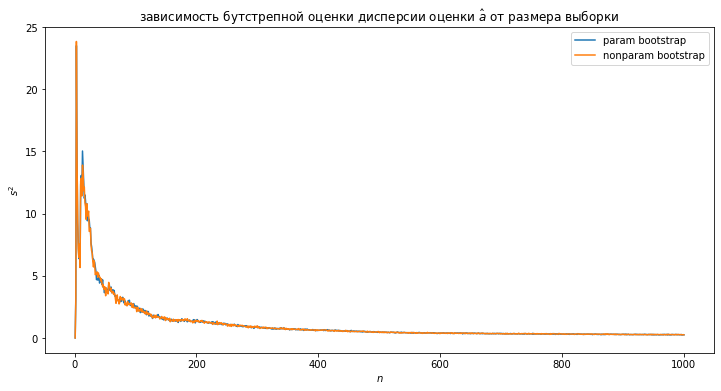

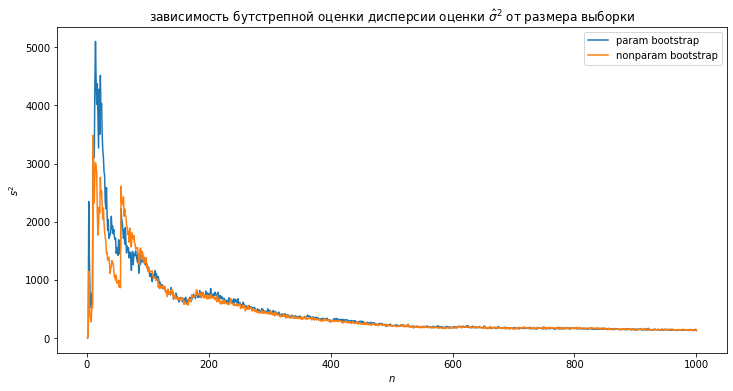

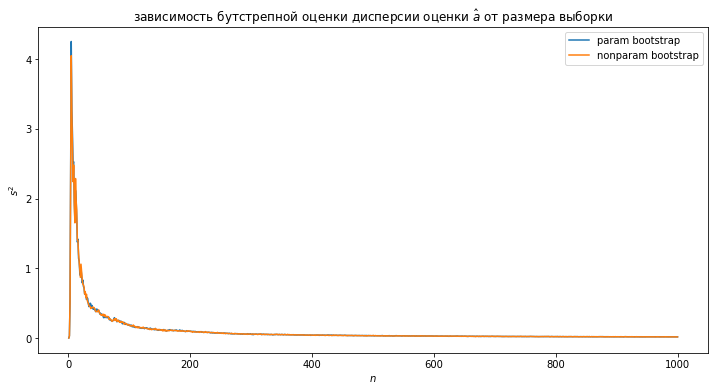

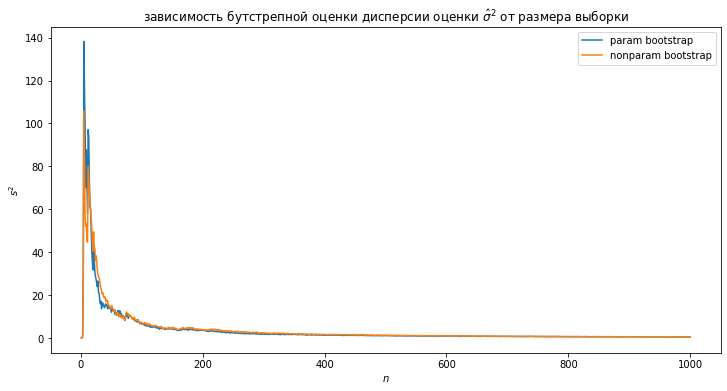

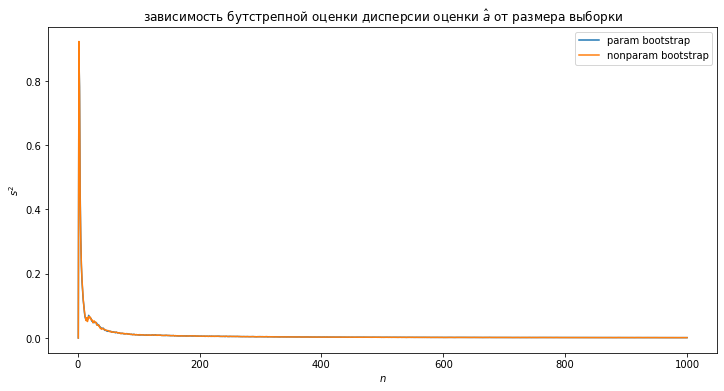

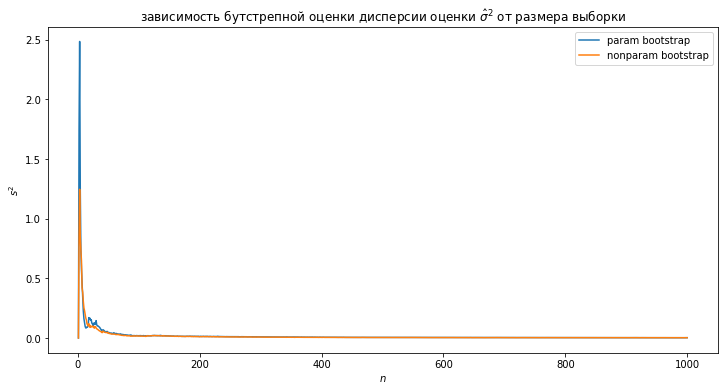

In [161]:
experiment(1, 16)
experiment(5, 4)
experiment(10, 1)

**Выводы**

Бутстрепная оценка дисперсии зависит от истинного значения параметра $\sigma$ - чем он меньше, тем меньше она. 

При достаточно большом значении $n$ оценка дисперсии очень мала.

Параметрический и непараметрический методы начиная с $n$ приблизительно равного 200 практически не различаются, значит, можно использовать любой из них. Для оценки параметра $\sigma$ при маленьких n чуть более точен непараметрический метод.

# Задача 2

Оценить параметр сдвига $x_0$ данной выборки с распределением Коши с плотностью $p(x) = \frac{1}{1 + (x - x_0)^2}$ методом максимального правдоподобия.

In [111]:
cauchy = pd.read_csv('Cauchy.csv')
cauchy.describe()

,661.39
count,999.000000
mean,662.370420
std,13.464303
min,476.290000
25%,661.110000
50%,662.100000
75%,663.100000
max,831.720000


In [ ]:
# логарифм от плотности
def ln_p(x, x0):
    return np.log(1 / (np.pi * (1 + (x - x0) ** 2)))

# логарифмическая функция правдоподобия
def likelyhood(sample, x0):
    return np.sum(ln_p(sample, x0))

In [106]:
def count_argmax(sample):
    # ищем аргмакс с шагом в 0.01
    args = np.arange(-1000, 1000, 0.01)
    argmax = args[0]
    max_likelyhood = likelyhood(sample, argmax)
    for x in args[1:]:
        new_likelyhood = likelyhood(sample, x)
        if new_likelyhood > max_likelyhood:
            max_likelyhood = new_likelyhood
            argmax = x
    return argmax

In [99]:
print("оценка по половине выбоки: ", count_argmax(cauchy.values[:500]))
print("оценка по всей выборке: ", count_argmax(cauchy.values))

оценка по половине выбоки:  662.0399999984884
оценка по всей выборке:  662.0499999984884


**Вывод**

Оценки максимального правдоподобия по половине выборки и по всей выборке практически не отличаются.
Также оценка приблизительно равна среднему значению по выборке, что показывает эффективность метода максимального правдоподобия.

# Задача 3

Дана выборка из распределения Вейбулла($\gamma$), посчитать оценку максимального правдоподобия. 
Произвести оценку по сетке в логарифмической шкале с шагом $10^{-3}$ с учетом того, что $log_{10}\gamma \in [-2, 2]$

In [2]:
weibull = pd.read_csv('Weibull.csv')
weibull.describe()

,0.29
count,3651.000000
mean,4.867762
std,17.024267
min,0.000000
25%,0.030000
50%,0.370000
75%,2.550000
max,368.800000


Некоторые значения в нашей выборке могут быть равны нулю. Чтобы корректно при этом считать логарифмическую
функцию правдоподобия, добавим к ним всем маленькую константу. Заметим, что это изменит значение 
функции правдоподобия одинаково для всех $\gamma$, поэтому на поиск argmax-а это не повлияет.

In [24]:
data = [x[0] if x != 0 else 0.001 for x in weibull.values]

Плотность распределения Вейбулла: $\gamma x^{\gamma-1} e^{-x^{\gamma}}$

In [ ]:
def ln_p(x, gamma):
    return np.log(gamma * (x ** (gamma - 1)) * np.exp(- (x ** gamma)))

def likelyhood(sample, gamma):
    return np.sum(ln_p(sample, gamma))

In [22]:
def count_argmax(sample):
    # рассчитаем количество пробных аргументов с учетом размера шага
    num_ = int((10**2 - 10**-2) / (10**-3))
    # получим сетку
    args = np.logspace(-2, 2, num=num_, base=10)
    argmax = args[0]
    max_likelyhood = likelyhood(sample, argmax)
    for gamma in args[1:]:
        new_likelyhood = likelyhood(sample, gamma)
        if new_likelyhood > max_likelyhood:
            max_likelyhood = new_likelyhood
            argmax = gamma
    return argmax

In [23]:
print("по первым четырем годам: ", count_argmax(data[:365*4]))
print("по всей выборке: ", count_argmax(data))

по первым четырем годам:  0.3754682366592499
по всей выборке:  0.3692601200644878


**Вывод**

Мы оценили выборку методом максимального правдоподобия по логарифмической сетке. Можно заметить, что оценки максимального правдоподобия для первых четырех лет и для всех 10 не сильно отличаются.